### 1) Imports

In [1]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField

%matplotlib inline

PyHEADTAIL v1.13.5


--> Use the longitudinal_tracking module instead.



/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


In [23]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [24]:
plt.close('all')

### 2) Variables we change

In [25]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = int(600)            #number of cycles to run the simulation for
decTurns = int(1)               #how often to record data

Q_y = 26.18                #How many times the particles oscillate in phase space each turn 
Q_x = 26.13                          # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

### 3) Variables we don't change

In [26]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma = 287.8
p0 = m_p*c*np.sqrt(gamma**2 - 1)
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference


# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments = 1
s = np.arange(0, n_segments+1)*circumference/n_segments
# optics at CC2
alpha_x = 0 * np.ones(n_segments)  # -0.9120242128
beta_x = 30.31164764 * np.ones(n_segments)
D_x = 0 * np.ones(n_segments) # -0.4954033073
alpha_y = 0 * np.ones(n_segments)  # 1.862209583
beta_y = 73.81671646 * np.ones(n_segments)
D_y = 0 * np.ones(n_segments)



Q_x, Q_y = 26.13, 26.18
Qp_x, Qp_y = 0, 0 #10

# detuning coefficients in (1/m)
app_x = 0.0  #2.4705e-15 #4e-11
app_xy = 0.0 #-0*2.25e-11
app_y = 0.0  #-7.31-14 #0*3e-11

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha = 1.9e-3
Q_s = 0.0051
h1, h2 = 4620, 9240
V1, V2 = 5.008e6, 0e6
dphi1, dphi2 = 0, np.pi
p_increment = 0 * e/c * circumference/(beta*c)

# CREATE DAMPER
# =============
dampingrate_y = 10 #40
damper = TransverseDamper(dampingrate_x, dampingrate_y)

# CREATE BEAM
# ===========
macroparticlenumber = int(500) # at least 5e5 particles are needed in the presence of the wakefields

charge = e
mass = m_p

R = circumference/(2*np.pi)
eta = alpha-1/gamma**2
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6     
epsn_z    = 2.5
sigma_z   = 0.155 #2*0.0755

sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp

# generate bunches for the different intensities
intensity = 3.0e10

bunch = generate_Gaussian6DTwiss(macroparticlenumber, intensity, charge, mass, circumference, gamma,
        alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)
xoffset = 0.25*sigma_x #5e-4
yoffset = 0.25*sigma_y #0.5*sigma_y #5e-4
    
bunch.x += xoffset
bunch.y += yoffset
    
afile = open(f'bunch', 'wb')
pickle.dump(bunch, afile)
afile.close()


Dampers active


### 4) Create transverse and longitudinal map

In [27]:
scale_factor = 2*bunch.p0  # scale the detuning coefficients in pyheadtail units
transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x*scale_factor, app_y*scale_factor, app_xy*scale_factor)])

longitudinal_map = LinearMap([alpha], circumference, Q_s)

### 5) Set up the acclerator

In [28]:
t0 = time.clock()

one_turn_map = []
for i, segment in enumerate(transverse_map):
    one_turn_map.append(segment)
    
one_turn_map.append(longitudinal_map)

n_damped_turns = int(n_turns/decTurns) # The total number of turns at which the data are damped.
                       # We want this number as an integer, so it can be used in the next functions. 


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


### 6) Start tracking

--> Done.
Simulation time in seconds: 8.228912


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


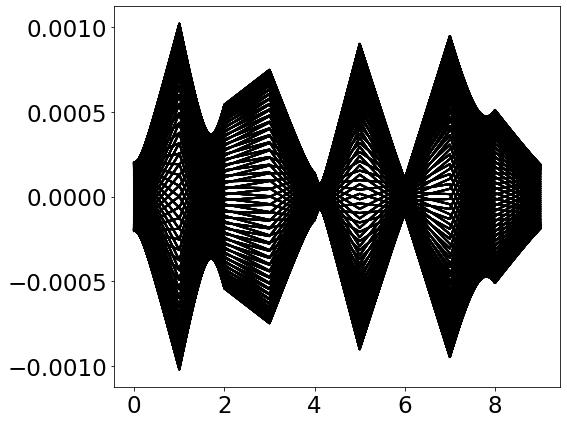

In [30]:
meanX = np.zeros(n_damped_turns)
meanY = np.zeros(n_damped_turns)
meanXsq = np.zeros(n_damped_turns)
meanYsq = np.zeros(n_damped_turns)
emitX = np.zeros(n_damped_turns)
emitY = np.zeros(n_damped_turns)
    
# Iterate over the intensities, reload bunch object from file for each intensisty
#intensity_list = np.linspace(0, 5e10, 5)

    
for i in range(n_turns):

    for m in one_turn_map:
        m.track(bunch)
        
    if i%decTurns is  0:
        j = int(i/decTurns)
        plt.plot(bunch.x[:10], c='k')
        plt.plot(np.mean(bunch.x), c='r')
        meanX[j] = np.mean(bunch.x)
        meanY[j] = np.mean(bunch.y)
        

dataExport = [meanX, meanY]#, meanXsq, meanYsq, emitX, emitY]

f = open(filename+'.txt', 'w')

with f:
    out = csv.writer(f, delimiter=',')
    out.writerows(zip(*dataExport))

print('--> Done.')

print("Simulation time in seconds: " + str(time.clock() - t0))



AttributeError: module 'matplotlib.pyplot' has no attribute 'xlable'

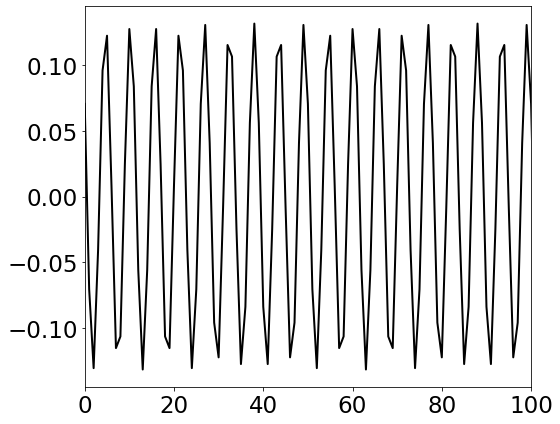

In [37]:
plt.plot(np.array(meanY)*1e3, '-', c='k')
plt.xlim(0.,100)
plt.xlable()

In [10]:
Qx_list, Qy_list = [], []
# Add tunes for intensity 0, there should be no tune shift
Qx_list.insert(0, 0.13)
Qy_list.insert(0, 0.18)

for intensity in intensity_list[1:]:
    # Load the file with all of the saved data from the run
    meanX, meanY = np.loadtxt(filename+f'_intensity{intensity/1e10:.2f}e10_ayy{app_y}_QpyQpx{Qp_x}.txt', delimiter = ",", unpack = True)
    
    Qx_list.append(pnf.get_tune(meanX))
    Qy_list.append(pnf.get_tune(meanY))

In [11]:
Qy_coherent = {}
Qx_coherent = {}
for i, intensity in enumerate(intensity_list):
    Qy_coherent[f'intensity {intensity}'] = Qy_list[i]
    Qx_coherent[f'intensity {intensity}'] = Qx_list[i]
    
save2pickle = True
if save2pickle:
    with open(f'Qy_coherent_vs_Intensity_6D_ayy{app_y}_wakesON_QpyQpx{Qp_x}.pkl', 'wb') as ff:
        pickle.dump(Qy_coherent, ff, pickle.HIGHEST_PROTOCOL)
    ff.close()
    
if save2pickle:
    with open(f'Qx_coherent_vs_Intensity_6D_ayy{app_y}_wakesON_Qpy{Qp_x}.pkl', 'wb') as ff:
        pickle.dump(Qx_coherent, ff, pickle.HIGHEST_PROTOCOL)
    ff.close()

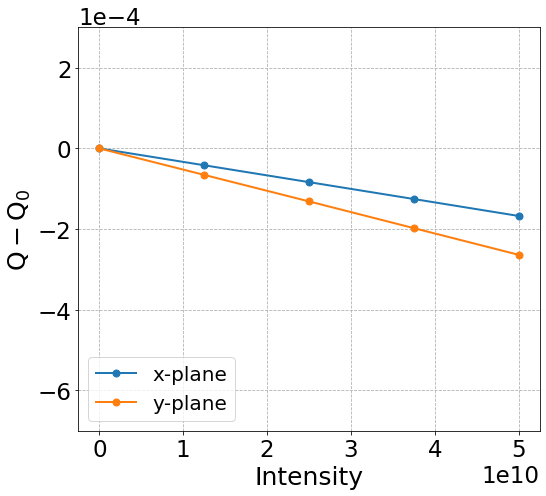

In [15]:
plt.plot(intensity_list, np.array(Qx_list)-0.13, '-o', c='C0', label='x-plane')
plt.plot(intensity_list, np.array(Qy_list)-0.18, '-o', c='C1', label='y-plane')


plt.ylabel(r'$\mathrm{Q-Q_0}$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Intensity')
plt.grid(linestyle='dashed')
plt.legend(loc=3)

plt.tight_layout()

# axis limits
plt.ylim(-7e-4, 3e-4)#3e-5

savefig = True
if savefig:
    plt.savefig(f'TuneShift_vs_Intensity_Q26wakes_ayy{app_y}_QpxQpy{Qp_x}_sigmaz{sigma_z}.png', bbox_inches='tight')

### End of main script

In [ ]:
DQy_theory_new = []

In [29]:
Qy_dict = pickle.load(open('./Qy_coherent_vs_Intensity_6D_ayy0.0_wakesON_QpyQpx0.pkl', 'rb'))
Qy_list = []
for intensity in intensity_list:
    Qy_list.append(Qy_dict[f'intensity {intensity}'])
print(Qy_list)

[0.18, 0.17993434423769697, 0.17986865424759674, 0.17980234468979797, 0.17973619330765983]


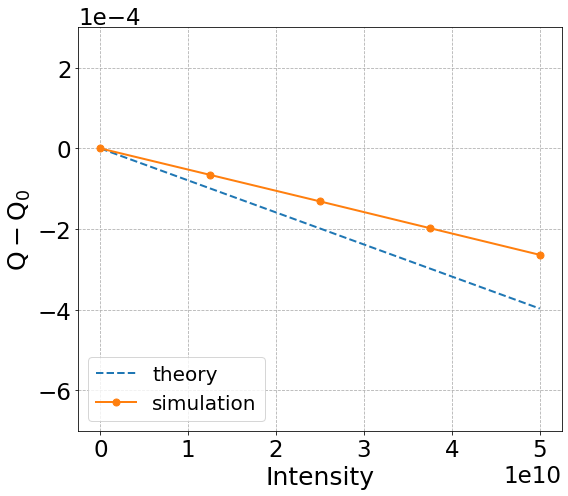

In [30]:
fig, ax = plt.subplots()

ax.plot(intensity_list, DQy_theory_new, '--', c='C0', label='theory')
ax.plot(intensity_list, np.array(Qy_list)-0.18, '-o', c='C1', label='simulation')

ax.set_ylabel(r'$\mathrm{Q-Q_0}$')
ax.set_xlabel('Intensity')

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid(linestyle='dashed')
ax.legend(loc=3)

plt.tight_layout()

# axis limits
ax.set_ylim(-7e-4, 3e-4)#3e-5

savefig = False
if savefig:
    plt.savefig(f'DQy_vs_Intensity_Q26wakes_ayy{app_y}_QpxQpy{Qp_x}_sigmaz{sigma_z}_vsSacherer.png', bbox_inches='tight')

### Upload coherent tune shift for SPS 270GeV as sent by Carlo on 29July2020

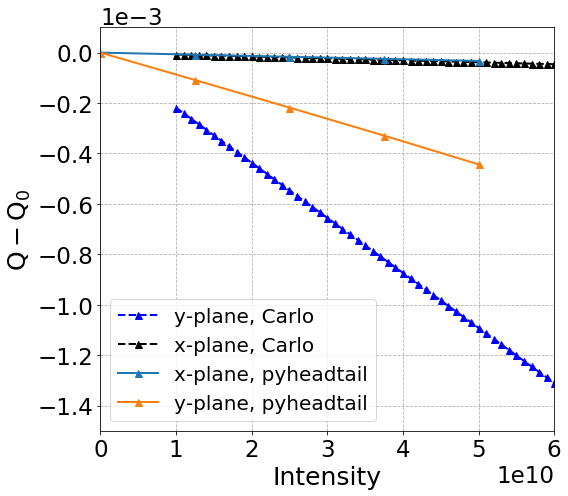

In [98]:
f=open('Tuneshift_270GeV_postLS2.csv',"r") # You can find this file in the following EOS folder:
#https://cernbox.cern.ch/index.php/apps/files/?dir=/2020/wakefields_SPS/Q20/coherent_tuneShift_from_Impedance_SPS_270GeV_from_Carlo&

intensity = []
tune_X = []
tune_Y = []



lines=f.readlines()

for x in lines:
    x = x.replace('i', 'j')
    x = x.strip('\n')
    x = x.split(',')
    
    
    intensity.append(complex(x[0]))
    tune_X.append(complex(x[1]))
    tune_Y.append(complex(x[2]))

plt.plot(np.array(intensity), np.real(tune_Y), '--^', c='b', label='y-plane, Carlo')
plt.plot(np.array(intensity), np.real(tune_X), '--^', c='k', label='x-plane, Carlo')


plt.xlabel('Intensity [1e10 protons]')
plt.ylabel('Coherent betatron tune shift')


plt.plot(intensity_list, np.array(Qx_list)-0.13, '-^', c='C0', label='x-plane, pyheadtail')
plt.plot(intensity_list, np.array(Qy_list)-0.18, '-^', c='C1', label='y-plane, pyheadtail')
plt.ylabel(r'$\mathrm{Q-Q_0}$')
plt.xlabel('Intensity')
plt.grid(linestyle='dashed')
plt.legend(loc=3)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlim(0, 6e10)
plt.ylim(-0.0015, 0.0001)
#plt.savefig('TuneShift_vs_Intensity_Q26wakes_offsetxy{xoffset*1e4}e-4.png')

plt.tight_layout()

savefig = False
if savefig:
    plt.savefig(f'TuneShift_vs_Intensity_offsetxy{xoffset*1e4}e-4_Q20_vs_CarloJuly2020.png')
    #plt.show()